TabNet
-----

* self-supervised 관련 리서치 중 대부분 이미지 데이터, 음성 데이터 등 비정형 데이터에 치중되어있다. 
* tabular data나 정형데이터에 적합한 self-supervised learning 방법이 없을까? 라는 생각에서 research를 해보았다.

* Arik S, & Pfister T. *TabNet: Attentive Interpretable Tabular Learning*
* https://arxiv.org/abs/1908.07442

In [2]:
## Package Setting

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from tqdm import tqdm

import random as rn
import pandas as pd 
import numpy as np

from numpy.random import rand, randn, randint

from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
# %matplotlib notebook
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import tensorflow as tf

import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Mean

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_addons.activations import sparsemax


from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### 주요특징

* 좌에서 우로 가면서 (sequential)하게 학습하며 feature selection을 하면서 학습하는 형식이다.
* Supervised fine tuning 하는 방법과 Unsupervised pre-trainining 방식이 있다. 왼쪽에 설명된 방식이 self-supervised learning과 관계가 있는데Encoder-Decoder 구조의 비지도 학습을 수행하여 masked 된 변수값을 예측한다.

<!-- ![tabnet_sparse_feature_selection](./tabnet_sparse_feature_selection.png) -->
<!-- <figure>
<img src="/Users/youngjeongju/Desktop/project/study/autoencoder/tabnet_sparse_feature_selection.png" alt="feature selection" style="width: 1000px;"/>
</figure> -->


![tabnet_sparse_feature_selection](./tabnet_sparse_feature_selection.png)
![Alt text](./tabnet_training_tuning.png)

## Architecture

![Alt text](./tabnet_architecture.png)

###  Encoder

* 각 decision step 내에서 feature transformer, attentive transformer, feature masking으로 구성되어있다. 
* split block은 feature transformer로부터 나온 representation을 두개로 나누어 하나는 ReLU를 태워 최종 output으로, 다른 하나는 attentive transformer로 넘겨준다.
* Mask block은 각 step에서 feature가 어떻게 작동하는지 알 수 있고 집계하여 feature importance를 확인할 수 있다.

![Alt text](./tabnet_ft.png)

#### Feature Transformer

* feature block 들이 연속적으로 이어져 있는 것으로 각  block은 Fully-Connected Layer(FC)와 Batch Normalization(BN), GLU(Gated Linear Unit) 로 구성되어있다.
* 한 block의 과정이 이루어진 후에 안정성 확보를 위해 sqrt(0.5)를 곱한다. 
* 예시) 2 레이어는 모든 decision 단계에서 공유되고, 나머지 2 레이어는 해당 decision step에서만 사용한다.
* 최종적으로 2개의 output이 출력된다. 
    - output 예측
    - 다음 step의 attentive transformer

##### GLU (Gated Linear Unit)
* 이전 레이어에서 나오는 정보를 제어하는 역할로 gradient가 급격하게 작아지거나 커지는 것을 막는다.

In [4]:
def glu(x, n_units=None):
    """Generalized linear unit nonlinear activation."""
    if n_units is None:
        n_units = tf.shape(x)[-1] // 2

    return x[..., :n_units] * tf.nn.sigmoid(x[..., n_units:])

In [5]:
class FeatureBlock(tf.keras.Model):
    """
    Implementation of a FL->BN->GLU block
    """
    def __init__(
        self,
        feature_dim,
        apply_glu = True,
        bn_momentum = 0.9,
        fc = None,
        epsilon = 1e-5,
    ):
        super(FeatureBlock, self).__init__()
        self.apply_gpu = apply_glu
        self.feature_dim = feature_dim
        units = feature_dim * 2 if apply_glu else feature_dim # desired dimension gets multiplied by 2
                                                              # because GLU activation halves it

        self.fc = tf.keras.layers.Dense(units, use_bias=False) if fc is None else fc # shared layers can get re-used
        self.bn = tf.keras.layers.BatchNormalization(momentum=bn_momentum, epsilon=epsilon)

    def call(self, x, training = None):
        x = self.fc(x) # inputs passes through the FC layer
        x = self.bn(x, training=training) # FC layer output gets passed through the BN
        if self.apply_gpu: 
            return glu(x, self.feature_dim) # GLU activation applied to BN output
        return x

In [6]:
class FeatureTransformer(tf.keras.Model):
    def __init__(
        self,
        feature_dim,
        fcs = [],
        n_total = 4,
        n_shared = 2,
        bn_momentum = 0.9,
    ):
        super(FeatureTransformer, self).__init__()
        self.n_total, self.n_shared = n_total, n_shared

        kwrgs = {
            "feature_dim": feature_dim,
            "bn_momentum": bn_momentum,
        }

        # build blocks
        self.blocks = []
        for n in range(n_total):
            # some shared blocks
            if fcs and n < len(fcs):
                self.blocks.append(FeatureBlock(**kwrgs, fc=fcs[n])) # Building shared blocks by providing FC layers
            # build new blocks
            else:
                self.blocks.append(FeatureBlock(**kwrgs)) # Step dependent blocks without the shared FC layers

    def call(self, x, training = None):
        # input passes through the first block
        x = self.blocks[0](x, training=training) 
        # for the remaining blocks
        for n in range(1, self.n_total):
            # output from previous block gets multiplied by sqrt(0.5) and output of this block gets added
            x = x * tf.sqrt(0.5) + self.blocks[n](x, training=training) 
        return x

    @property
    def shared_fcs(self):
        return [self.blocks[i].fc for i in range(self.n_shared)]

####  Attentive Transformer

![Alt text](./tabnet_at.png)

* Attentive Transformer는 feature transformer에서 split되어 나온 output중 하나를 input으로 받아 FC, BN, Prior scales, Sparsemax layer를 통과한다. 
* prior scale을 고려한 sparsemax 활성화를 통해 각 단계에서 feature을 selection한다. 
* 인코딩된 decision은 attentive transformer 블록을 거쳐 trainable mask로 변환된다.
* 예시) 단일 네트워크 구조의 attentive transformer 구조

##### Sparsemax activation

* sparse한 데이터셋에 적용했을 때 좋은 성능을 보이는 activation function

In [7]:
class AttentiveTransformer(tf.keras.Model):
    def __init__(self, feature_dim):
        super(AttentiveTransformer, self).__init__()
        self.block = FeatureBlock(
            feature_dim,
            apply_glu=False, #sparsemax instead of glu
        )

    def call(self, x, prior_scales, training=None):
        x = self.block(x, training=training)
        return sparsemax(x * prior_scales)

##### Feature selection 하는 과정

* prior scale layer는 이전 step까지 각 기능이 얼마나 많이 사용되었는지 합산한다. 
* mask : 어떤 feature을 주로 사용할 것인지에 대한 정보가 있음. 다음 step에서 mask 정보를 재활용할 수 있다.
* mask를 얼마나 재활용할지를 relaxation factor($\gamma$)을 통해 조절한다.

![Alt text](./tabnet_attentive_transformer_ex.png)

* 선택된 feature들의 sparsity를 컨트롤하기 위해서 entropy form 안에서 sparsity 정규화를 실행한다.

![Alt text](./tabnet_sparsity.png)

### Decoder

![Alt text](./tabnet_decoder.png)

* 각 단계에서 feature transformer 블록으로 구성된다.
* Self-supervised learning : Decoder의 부분을 통해서 pre-training이 이루어진다.
    - tabnet encoder를 통해서 feature engineering 효과를 내고, decision making 부분을 통해 feature selection을 한다.
    - 서로 관계가 있는 변수들은 마스킹된 자체 모니터링 학습을 통해서 feature이 재구성되며 학습 작업의 인코더 모델을 개선한다.

### TabNet full code

In [8]:
# TabNet

class TabNet(tf.keras.Model):
    def __init__(
        self,
        num_features,
        feature_dim,
        output_dim,
        n_step = 2,
        n_total = 4,
        n_shared = 2,
        relaxation_factor = 1.5,
        bn_epsilon = 1e-5,
        bn_momentum = 0.7,
        sparsity_coefficient = 1e-5
    ):
        super(TabNet, self).__init__()
        self.output_dim, self.num_features = output_dim, num_features
        self.n_step, self.relaxation_factor = n_step, relaxation_factor
        self.sparsity_coefficient = sparsity_coefficient

        self.bn = tf.keras.layers.BatchNormalization(
            momentum=bn_momentum, epsilon=bn_epsilon
        )

        kargs = {
            "feature_dim": feature_dim + output_dim,
            "n_total": n_total,
            "n_shared": n_shared,
            "bn_momentum": bn_momentum
        }

        # first feature transformer block is built first to get the shared blocks
        self.feature_transforms = [FeatureTransformer(**kargs)]
        self.attentive_transforms = []
            
        # each step consists out of FT and AT
        for i in range(n_step):
            self.feature_transforms.append(
                FeatureTransformer(**kargs, fcs=self.feature_transforms[0].shared_fcs)
            )
            self.attentive_transforms.append(
                AttentiveTransformer(num_features)
            )
        
        # Final output layer
        self.head = tf.keras.layers.Dense(2, activation="softmax", use_bias=False)

    def call(self, features, training = None):

        bs = tf.shape(features)[0] # get batch shape
        out_agg = tf.zeros((bs, self.output_dim)) # empty array with outputs to fill
        prior_scales = tf.ones((bs, self.num_features)) # prior scales initialised as 1s
        importance = tf.zeros([bs, self.num_features]) # importances
        masks = []

        features = self.bn(features, training=training) # Batch Normalisation
        masked_features = features

        total_entropy = 0.0

        for step_i in range(self.n_step + 1):
            # (masked) features go through the FT
            x = self.feature_transforms[step_i](
                masked_features, training=training
            )
            
            # first FT is not used to generate output
            if step_i > 0:
                # first half of the FT output goes towards the decision 
                out = tf.keras.activations.relu(x[:, : self.output_dim])
                out_agg += out
                scale_agg = tf.reduce_sum(out, axis=1, keepdims=True) / (self.n_step - 1)
                importance += mask_values * scale_agg
                

            # no need to build the features mask for the last step
            if step_i < self.n_step:
                # second half of the FT output goes as input to the AT
                x_for_mask = x[:, self.output_dim :]
                
                # apply AT with prior scales
                mask_values = self.attentive_transforms[step_i](
                    x_for_mask, prior_scales, training=training
                )

                # recalculate the prior scales
                prior_scales *= self.relaxation_factor - mask_values
                
                # multiply the second half of the FT output by the attention mask to enforce sparsity
                masked_features = tf.multiply(mask_values, features)

                # entropy is used to penalize the amount of sparsity in feature selection
                total_entropy += tf.reduce_mean(
                    tf.reduce_sum(
                        tf.multiply(-mask_values, tf.math.log(mask_values + 1e-15)),
                        axis=1,
                    )
                )
                
                # append mask values for later explainability
                masks.append(tf.expand_dims(tf.expand_dims(mask_values, 0), 3))
                
        #Per step selection masks        
        self.selection_masks = masks
        
        # Final output
        final_output = self.head(out)
        
        # Add sparsity loss
        loss = total_entropy / (self.n_step-1)
        self.add_loss(self.sparsity_coefficient * loss)
        
        return final_output, importance

## Example: Fraud Detection 

- Supervised Learning

### Data
* Data Shape : (284807, 31)
* x: v1~v28, time, amount
* y: label

In [9]:
df_ = pd.read_csv('./data/creditcard.csv').reset_index(drop=True)

# 데이터 변수 조정

df_.columns = map(str.lower, df_.columns)
df_.rename(columns={'class': 'label'}, inplace=True)

df_.shape

(284807, 31)

### Preprocessing

* amount 변수 log 형태로 전환
* time 변수 제거
* minmax scaler 사용

In [10]:
# amount
df_['amount'] = np.log(df_.amount + 1)

# time
df_["time"] = df_["time"].apply(lambda x : x / 3600 % 24)

# drop time variable
df_ = df_.drop('time', axis=1)

# scaler
scaler = MinMaxScaler()
colnames_all = list(df_)
df_[colnames_all] = scaler.fit_transform(df_[colnames_all])

df_.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.493873,0.0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.128583,0.0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.584923,0.0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.475117,0.0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.419792,0.0


### Data split

* df_train, df_valid, df_test  = 6:2:2

In [11]:
df_train_, df_test = train_test_split(df_, test_size=0.2)
df_train, df_valid = train_test_split(df_train_, test_size=0.2)

In [12]:
x_train = df_train.drop(['label'], axis = 1)
y_train = df_train["label"].values

x_valid = df_valid.drop(['label'], axis = 1)
y_valid = df_valid["label"].values

x_test = df_test.drop(['label'], axis=1)
y_test = df_test['label'].values

scaler = MinMaxScaler()
colnames_all = list(x_train.columns)
x_train[colnames_all] = scaler.fit_transform(x_train[colnames_all])
x_test = scaler.transform(x_test)
x_valid[colnames_all] = scaler.fit_transform(x_valid[colnames_all])

### TF dataset만들기

In [13]:
def prepare_tf_dataset(
    X,
    batch_size,
    y = None,
    shuffle = True, #false
    drop_remainder = False,
):
    size_of_dataset = len(X)
    if y is not None:
        y = tf.one_hot(y.astype(int), 2)
        ds = tf.data.Dataset.from_tensor_slices((np.array(X.astype(np.float32)), y))
    else:
        ds = tf.data.Dataset.from_tensor_slices(np.array(X.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(buffer_size=size_of_dataset)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    autotune = tf.data.experimental.AUTOTUNE
    ds = ds.prefetch(autotune)
    return ds

train_ds = prepare_tf_dataset(x_train, 1000, y_train)
val_ds = prepare_tf_dataset(x_valid, 1000, y_valid)
test_ds = prepare_tf_dataset(x_test, 1000)

### Modeling

In [14]:
tabnet = TabNet(num_features = x_train.shape[1],
                output_dim = 128,
                feature_dim = 128,
                n_step = 2, 
                relaxation_factor= 2.2,
                sparsity_coefficient=2.37e-07,
                n_shared = 2,
                bn_momentum = 0.9245)


# Early stopping based on validation loss    
cbs = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    )]

# Optimiser 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=10)

# Second loss in None because we also output the importances
loss = [tf.keras.losses.CategoricalCrossentropy(from_logits=False), None]

# Compile the model
tabnet.compile(optimizer,
               loss=loss)

# Train the model
tabnet.fit(train_ds, 
           epochs=1000, 
           validation_data=val_ds,
           callbacks=cbs,
           verbose=1,
          class_weight={
              0:1,
              1: 10
          })

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Colocations handled automatically by placer.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this 

/opt/anaconda3/envs/py_3_6/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


19/19 [==============================] - 27s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.6886 - output_1_loss: 0.6886 - val_loss: 0.6829 - val_output_1_loss: 0.6829
Epoch 2/1000
19/19 [==============================] - 26s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.4213 - output_1_loss: 0.4213 - val_loss: 0.5989 - val_output_1_loss: 0.5989
Epoch 3/1000
19/19 [==============================] - 26s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.2616 - output_1_loss: 0.2616 - val_loss: 0.4288 - val_output_1_loss: 0.4288
Epoch 4/1000
19/19 [==============================] - 27s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.1649 - output_1_loss: 0.1649 - val_loss: 0.1011 - val_output_1_loss: 0.1011
Epoch 5/1000
19/19 [==============================] - 27s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.1108 - output_1_loss: 0.1108 - val_loss: 0.0455 - val_output_1_loss: 0.0455
Epoch 6/1000
19/19 [==============================] - 26s 1s/step - batch: 9.0000 - size: 1.0000 -

19/19 [==============================] - 25s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.0082 - output_1_loss: 0.0082 - val_loss: 0.0239 - val_output_1_loss: 0.0239
Epoch 46/1000
19/19 [==============================] - 26s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.0081 - output_1_loss: 0.0081 - val_loss: 0.0212 - val_output_1_loss: 0.0212
Epoch 47/1000
19/19 [==============================] - 25s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.0079 - output_1_loss: 0.0079 - val_loss: 0.0207 - val_output_1_loss: 0.0207
Epoch 48/1000
19/19 [==============================] - 24s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.0076 - output_1_loss: 0.0076 - val_loss: 0.0205 - val_output_1_loss: 0.0205
Epoch 49/1000
19/19 [==============================] - 25s 1s/step - batch: 9.0000 - size: 1.0000 - loss: 0.0075 - output_1_loss: 0.0075 - val_loss: 0.0192 - val_output_1_loss: 0.0192
Epoch 50/1000
19/19 [==============================] - 26s 1s/step - batch: 9.0000 - size: 1.0

### Validation 성능 확인 

In [15]:
val_preds, val_imps = tabnet.predict(val_ds)

In [18]:
print('Test ROC AUC', np.round(roc_auc_score(y_valid, val_preds[:, 1]), 4))
print('Test PR AUC', np.round(average_precision_score(y_valid, val_preds[:, 1]), 4))

Test ROC AUC 0.4855
Test PR AUC 0.002


### Prediction

In [19]:
test_preds, test_imp = tabnet.predict(test_ds)

In [20]:
temp = pd.DataFrame({'y':y_test, 'yhat':test_preds[:,1]})

In [33]:
y_pred = np.where(test_preds[:, 1] > 0.005, 1, 0)
# y_pred = np.percentile(test_preds[:, 1],5)
print(y_pred)

[1 0 0 ... 1 0 0]


In [35]:
print ('Accuracy Score :',np.round(accuracy_score(y_test, y_pred),2) )
print ('Precision :',np.round(precision_score(y_test, y_pred),2))
print ('Recall :',np.round(recall_score(y_test, y_pred),2))
print ('F1 :',np.round(f1_score(y_test, y_pred),2))

Accuracy Score : 0.63
Precision : 0.0
Recall : 0.38
F1 : 0.0


Confusion Matrix :


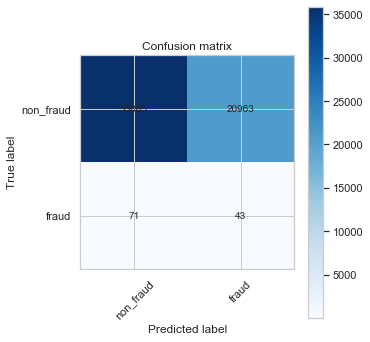

In [36]:
cm = confusion_matrix(y_test, y_pred)
target_names = ['non_fraud', 'fraud']

print ('Confusion Matrix :')

def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm,target_names)

### 의문점
   - self-supervised 부분이 autoencoder랑 다른점이 무엇인지?
   - !!!이미 package가 나와있음!!!!

### 참고 문헌 / 코드

* https://today-1.tistory.com/54
* https://dacon.io/codeshare/2515
* https://velog.io/@jkl133/TabNet-Gradient-Boosting%EC%9D%98-%EC%A2%85%EB%A7%90
* https://data-newbie.tistory.com/378?category=753185
</br>

* https://github.com/google-research/google-research
* https://github.com/aruberts/blogs/blob/main/TabNet%20Classification%20Example.ipynb
